# Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from config import Config
from utils import get_regularized_model, get_image_data_generator
from data_preprocessing import load_and_preprocess_images, encode_labels, load_data

# Load data & Create data generators

In [2]:
x_train, x_val, y_train, y_val, label_to_name = load_data("Dataset/images/", "Dataset/labels.csv")

# Encode data in the right format
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)

x_train_processed = load_and_preprocess_images(x_train, target_size=(224, 224))
x_val_processed = load_and_preprocess_images(x_val, target_size=(224, 224))

y_train_encoded = encode_labels(y_train)
y_val_encoded = encode_labels(y_val)

train_data_generator = get_image_data_generator(
    Config.rotation_range,
    Config.width_shift_range,
    Config.height_shift_range,
    Config.shear_range,
    Config.zoom_range,
    Config.horizontal_flip,
    Config.vertical_flip
)

# No data augmentation for validation
val_data_generator = get_image_data_generator(0, 0, 0, 0, 0, False, False)  


# Define & Compile the model

In [5]:
model = get_regularized_model(Config.input_shape, Config.num_classes, Config.dropout_rate, Config.l2_regularization)

model.compile(optimizer=Adam(learning_rate=Config.learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks

In [6]:
checkpoint = ModelCheckpoint("Results/Model_Weights/best_model.h5", save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model

In [7]:
history = model.fit(
    train_data_generator.flow(x_train_processed, y_train_encoded, batch_size=Config.batch_size),
    steps_per_epoch=len(x_train_processed) // Config.batch_size,
    epochs=Config.epochs,
    validation_data=val_data_generator.flow(x_val_processed, y_val_encoded, batch_size=Config.batch_size),
    validation_steps=len(x_val_processed) // Config.batch_size,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/20


3/3 [==============================] - ETA: 0s - loss: 2.8876 - accuracy: 0.0606

f:\Desktop\Programming\DeepLearning\MiniProject\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 66s 27s/step - loss: 2.8876 - accuracy: 0.0606 - val_loss: 2.4503 - val_accuracy: 0.1667
Epoch 2/20
3/3 [==============================] - 6s 2s/step - loss: 2.2974 - accuracy: 0.1818 - val_loss: 2.1866 - val_accuracy: 0.1667
Epoch 3/20
3/3 [==============================] - 6s 2s/step - loss: 2.1678 - accuracy: 0.1515 - val_loss: 2.1220 - val_accuracy: 0.1667
Epoch 4/20
3/3 [==============================] - 6s 2s/step - loss: 2.1389 - accuracy: 0.1515 - val_loss: 2.1443 - val_accuracy: 0.1667
Epoch 5/20
3/3 [==============================] - 6s 2s/step - loss: 2.1317 - accuracy: 0.2727 - val_loss: 2.1424 - val_accuracy: 0.1667
Epoch 6/20
3/3 [==============================] - 6s 2s/step - loss: 2.1038 - accuracy: 0.1515 - val_loss: 2.1208 - val_accuracy: 0.1667


# Save the final model & training history

In [8]:
model.save("Results/Model_Weights/final_model.h5")
np.save("Results/Plots/training_history.npy", history.history)

# Evaluate the model on the test set

In [9]:
test_data_generator = get_image_data_generator(0, 0, 0, 0, 0, False, False)

# Load & evaluae the best model

In [10]:
best_model = load_model("Results/Model_Weights/best_model.h5")

# Evaluate the model
eval_result = best_model.evaluate(test_data_generator.flow(x_val_processed, y_val_encoded, batch_size=Config.batch_size),
                                  steps=len(x_val) // Config.batch_size)
print("\nEvaluation Loss: {:.4f}".format(eval_result[0]))
print("Evaluation Accuracy: {:.2%}".format(eval_result[1]))

1/1 [==============================] - 1s 542ms/step - loss: 2.4503 - accuracy: 0.1667

Evaluation Loss: 2.4503
Evaluation Accuracy: 16.67%


# Predict classes for test set

In [11]:
y_pred = best_model.predict(test_data_generator.flow(x_val_processed, batch_size=Config.batch_size)).argmax(axis=1)

1/1 [==============================] - 1s 570ms/step


# Convert numerical labels back to student names

In [12]:
print(y_val)
print(y_val_encoded)
print(y_pred)

['CHEMMAMI_Abdrezak' 'HOUACHE_Mohamed' 'HOUASNIA_AymenAhmed'
 'HOUACHE_Mohamed' 'TERCHI_Chaima' 'KHALFI_Abdelwadoud'
 'CHEMMAMI_Abdrezak' 'HOUASNIA_AymenAhmed' 'TERCHI_Chaima' 'ZERAIB_Ranya'
 'BERGHOUTH_Imene' 'KHALFI_Abdelwadoud']
[1 2 3 2 5 4 1 3 5 6 0 4]
[1 1 1 1 1 1 1 1 1 1 1 1]


In [16]:
y_val = ['CHEMMAMI_Abdrezak', 'HOUACHE_Mohamed', 'HOUASNIA_AymenAhmed', 'HOUACHE_Mohamed', 'TERCHI_Chaima', 'KHALFI_Abdelwadoud', 'CHEMMAMI_Abdrezak', 'HOUASNIA_AymenAhmed', 'TERCHI_Chaima', 'ZERAIB_Ranya', 'BERGHOUTH_Imene', 'KHALFI_Abdelwadoud']

# Encode y_val to get y_val_encoded
y_val_encoded = encode_labels(y_val)

# Assuming y_pred_encoded contains encoded labels directly
y_pred_encoded = np.array(y_pred)

# Create a mapping from encoded labels to class names
label_to_name_encoded = {label: name for name, label in zip(y_val, y_val_encoded)}

# Map encoded labels back to class names for y_val_encoded and y_pred_encoded
y_val_names = [label_to_name_encoded[label] for label in y_val_encoded]
y_pred_names = [label_to_name_encoded[label] for label in y_pred_encoded]

print("Actual labels (y_val_names):", y_val_names)
print("Predicted labels (y_pred_names):", y_pred_names)

Actual labels (y_val_names): ['CHEMMAMI_Abdrezak', 'HOUACHE_Mohamed', 'HOUASNIA_AymenAhmed', 'HOUACHE_Mohamed', 'TERCHI_Chaima', 'KHALFI_Abdelwadoud', 'CHEMMAMI_Abdrezak', 'HOUASNIA_AymenAhmed', 'TERCHI_Chaima', 'ZERAIB_Ranya', 'BERGHOUTH_Imene', 'KHALFI_Abdelwadoud']
Predicted labels (y_pred_names): ['CHEMMAMI_Abdrezak', 'CHEMMAMI_Abdrezak', 'CHEMMAMI_Abdrezak', 'CHEMMAMI_Abdrezak', 'CHEMMAMI_Abdrezak', 'CHEMMAMI_Abdrezak', 'CHEMMAMI_Abdrezak', 'CHEMMAMI_Abdrezak', 'CHEMMAMI_Abdrezak', 'CHEMMAMI_Abdrezak', 'CHEMMAMI_Abdrezak', 'CHEMMAMI_Abdrezak']


# Print classification report and confusion matrix

In [18]:
print("\nClassification Report:")
print(classification_report(y_val_names, y_pred_names))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val_names, y_pred_names))


Classification Report:
                     precision    recall  f1-score   support

    BERGHOUTH_Imene       0.00      0.00      0.00         1
  CHEMMAMI_Abdrezak       0.17      1.00      0.29         2
    HOUACHE_Mohamed       0.00      0.00      0.00         2
HOUASNIA_AymenAhmed       0.00      0.00      0.00         2
 KHALFI_Abdelwadoud       0.00      0.00      0.00         2
      TERCHI_Chaima       0.00      0.00      0.00         2
       ZERAIB_Ranya       0.00      0.00      0.00         1

           accuracy                           0.17        12
          macro avg       0.02      0.14      0.04        12
       weighted avg       0.03      0.17      0.05        12


Confusion Matrix:
[[0 1 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 1 0 0 0 0 0]]


f:\Desktop\Programming\DeepLearning\MiniProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\Desktop\Programming\DeepLearning\MiniProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\Desktop\Programming\DeepLearning\MiniProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

# Plot training history

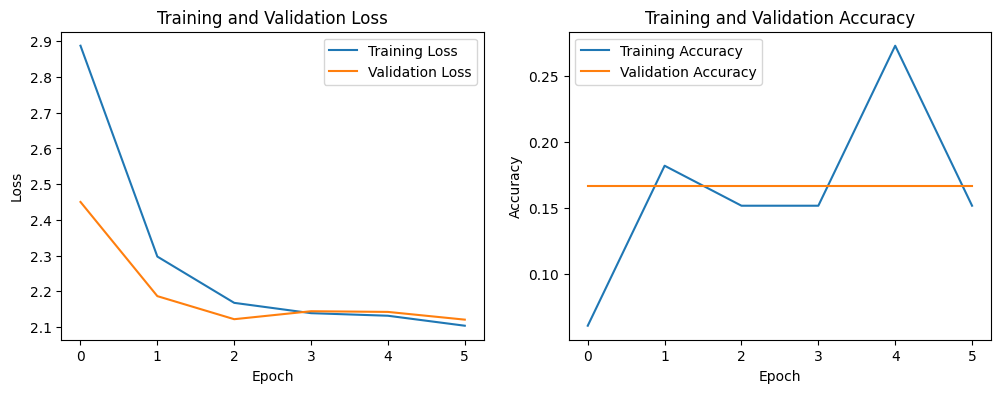

In [19]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Save the plots

In [20]:
plt.savefig("Results/Plots/training_and_validation_plots.png")

<Figure size 640x480 with 0 Axes>